# K-Means

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import f_oneway, chi2_contingency

## Load Preprocessed Data

In [2]:
X = pd.read_csv("/content/X_preprocessed.csv")
y = pd.read_csv("/content/y_preprocessed.csv").values.ravel()  # For evaluation only

## Determination of Optimul Number of Clusters

### Elbow Method and Silhouette Scores

In [3]:
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

### Elbow Method and Silhouette Scores Plots

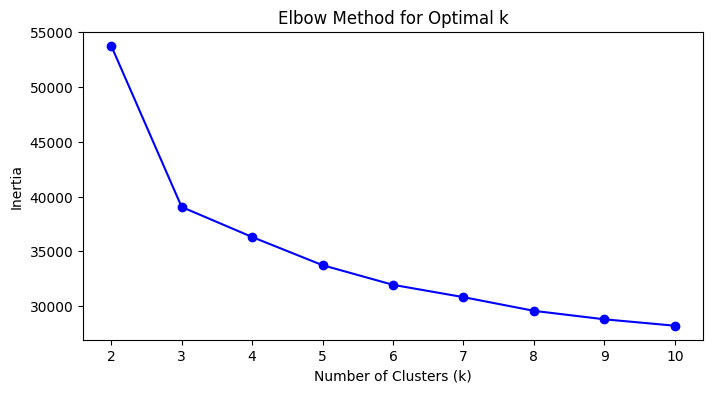

In [4]:
# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

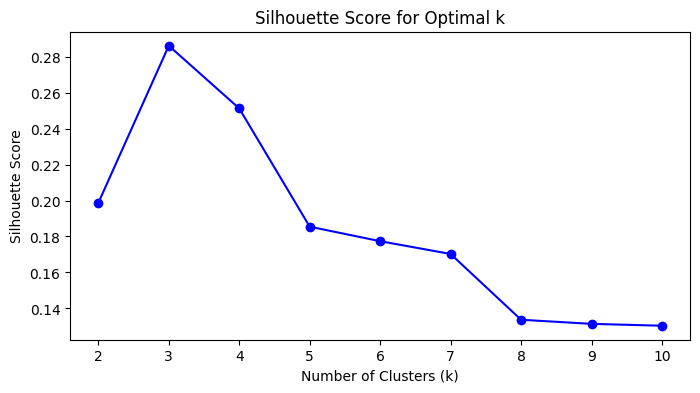

In [5]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

### Optimul k

In [6]:
# Choose optimal k
optimal_k = 3

## Train K-Means

In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

## Validations

### Cluster Labeling

In [8]:
# Add cluster labels to data
X_clustered = X.copy()
X_clustered['Cluster'] = clusters
X_clustered['Churn'] = y

### Cluster Characteristics

In [9]:
# Analyze cluster characteristics
cluster_summary = X_clustered.groupby('Cluster').mean()
churn_by_cluster = X_clustered.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()

### Interpretation Logic

In [10]:
# Define cluster names based on interpretation logic
cluster_names = {}
key_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'Churn']
for cluster_id in range(optimal_k):
    cluster_data = cluster_summary.loc[cluster_id, key_features]
    churn_yes = churn_by_cluster.loc[cluster_id, 1] if 1 in churn_by_cluster.columns else 0

    name_parts = []
    if cluster_data['tenure'] > 0.5:
        name_parts.append("Long-Term")
    elif cluster_data['tenure'] < -0.5:
        name_parts.append("Short-Term")
    else:
        name_parts.append("Moderate")

    if cluster_data['MonthlyCharges'] > 0.5:
        name_parts.append("High-Cost")
    elif cluster_data['MonthlyCharges'] < -0.5:
        name_parts.append("Low-Cost")
    else:
        name_parts.append("Mid-Cost")

    if churn_yes > 0.5:
        name_parts.append("High-Risk")
    elif churn_yes < 0.2:
        name_parts.append("Low-Risk")
    else:
        name_parts.append("Mixed-Risk")

    cluster_names[cluster_id] = " ".join(name_parts)

### Mapping Clusters with DataFrame

In [11]:
# Map cluster names to the DataFrame
X_clustered['Cluster_Name'] = X_clustered['Cluster'].map(cluster_names)

### Cluster Validation Metrics

In [12]:
# Cluster Validation Metrics
silhouette_avg = silhouette_score(X, clusters)
davies_bouldin = davies_bouldin_score(X, clusters)
print(f"\nCluster Validation Metrics:")
print(f" - Silhouette Score (avg): {silhouette_avg:.3f} (closer to 1 is better)")
print(f" - Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")


Cluster Validation Metrics:
 - Silhouette Score (avg): 0.286 (closer to 1 is better)
 - Davies-Bouldin Index: 1.434 (lower is better)


### Silhouette Plot

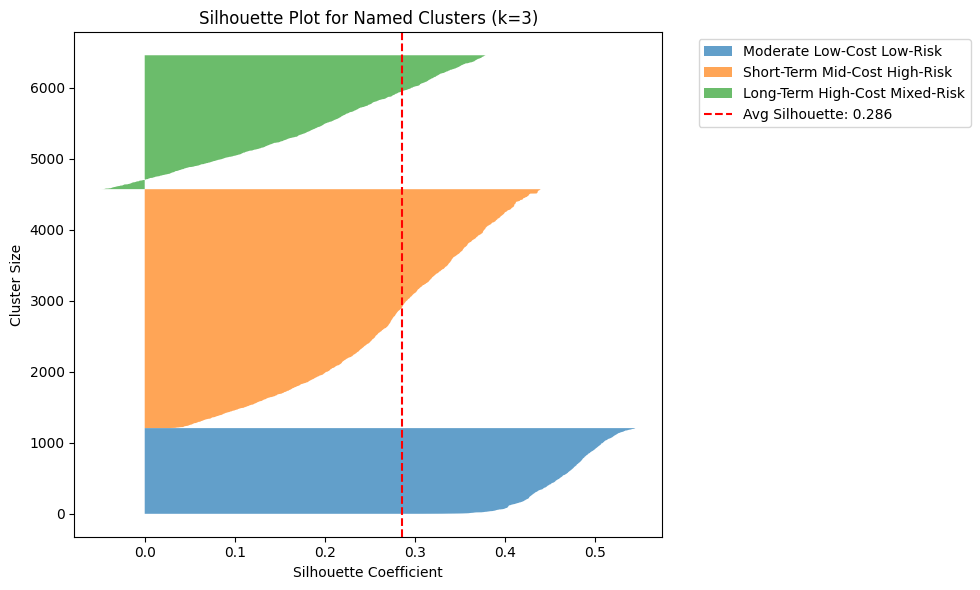

In [13]:
# Silhouette Plot
silhouette_vals = silhouette_samples(X, clusters)
y_lower, y_upper = 0, 0
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, label=cluster_names[i])
    y_lower += len(cluster_silhouette_vals)
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Avg Silhouette: {silhouette_avg:.3f}')
plt.title(f'Silhouette Plot for Named Clusters (k={optimal_k})')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Size')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Statistical Tests for Cluster Distinctness

In [14]:
# Statistical Tests for Cluster Distinctness
print("\nStatistical Tests for Cluster Distinctness:")
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
anova_results = {}
for feature in numerical_features:
    groups = [X_clustered[feature][X_clustered['Cluster'] == i] for i in range(optimal_k)]
    f_stat, p_value = f_oneway(*groups)
    anova_results[feature] = p_value
    print(f" - ANOVA for {feature}: p-value = {p_value:.4f} {'(significant)' if p_value < 0.05 else '(not significant)'}")

categorical_columns = [col for col in X.columns if col.startswith(('Contract_', 'InternetService_', 'PaymentMethod_'))]
chi2_results = {}
for col in categorical_columns[:5]:  # Limit to top 5 for brevity
    contingency_table = pd.crosstab(X_clustered['Cluster'], X_clustered[col])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = p_value
    print(f" - Chi-Square for {col}: p-value = {p_value:.4f} {'(significant)' if p_value < 0.05 else '(not significant)'}")


Statistical Tests for Cluster Distinctness:
 - ANOVA for tenure: p-value = 0.0000 (significant)
 - ANOVA for MonthlyCharges: p-value = 0.0000 (significant)
 - ANOVA for TotalCharges: p-value = 0.0000 (significant)
 - Chi-Square for InternetService_DSL: p-value = 0.0000 (significant)
 - Chi-Square for InternetService_Fiber optic: p-value = 0.0000 (significant)
 - Chi-Square for InternetService_No: p-value = 0.0000 (significant)
 - Chi-Square for Contract_Month-to-month: p-value = 0.0000 (significant)
 - Chi-Square for Contract_One year: p-value = 0.0000 (significant)


### Scatter Plot

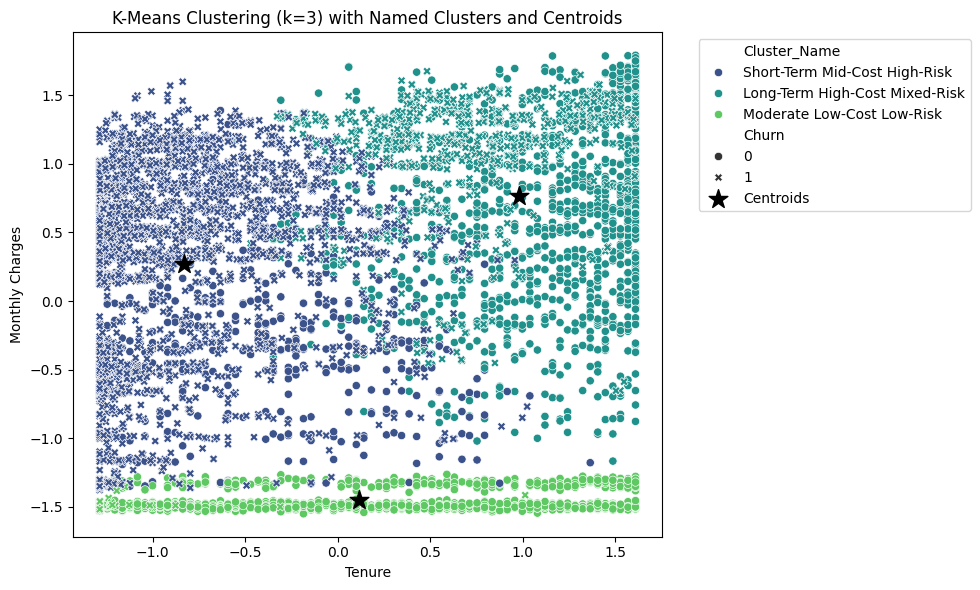

In [15]:
# Enhanced Scatter Plot with Centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_clustered, x='tenure', y='MonthlyCharges', hue='Cluster_Name', style='Churn', palette='viridis', legend='full')
plt.scatter(X_clustered.groupby('Cluster')['tenure'].mean(),
            X_clustered.groupby('Cluster')['MonthlyCharges'].mean(),
            c='black', marker='*', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={optimal_k}) with Named Clusters and Centroids')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### PCA


Explained Variance Ratio (2 components): 0.51


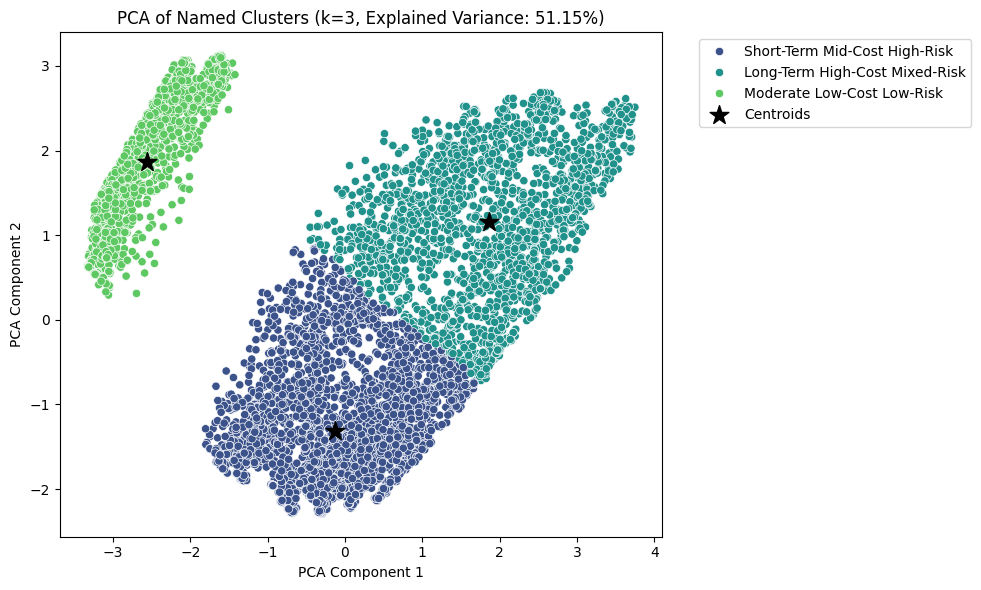

In [16]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"\nExplained Variance Ratio (2 components): {explained_variance:.2f}")

# Convert centroids to DataFrame with feature names
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_clustered['Cluster_Name'], palette='viridis', legend='full')
plt.scatter(pca.transform(centroids_df)[:, 0],
            pca.transform(centroids_df)[:, 1],
            c='black', marker='*', s=200, label='Centroids')
plt.title(f'PCA of Named Clusters (k={optimal_k}, Explained Variance: {explained_variance:.2%})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Boxplots for Numerical Features

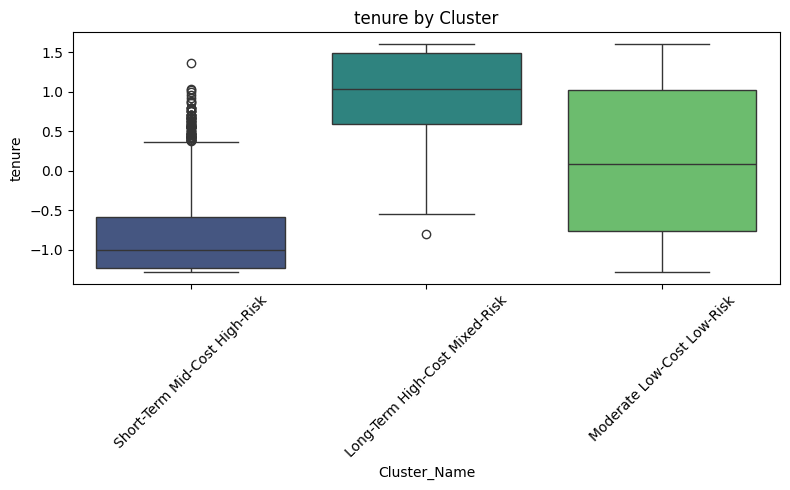

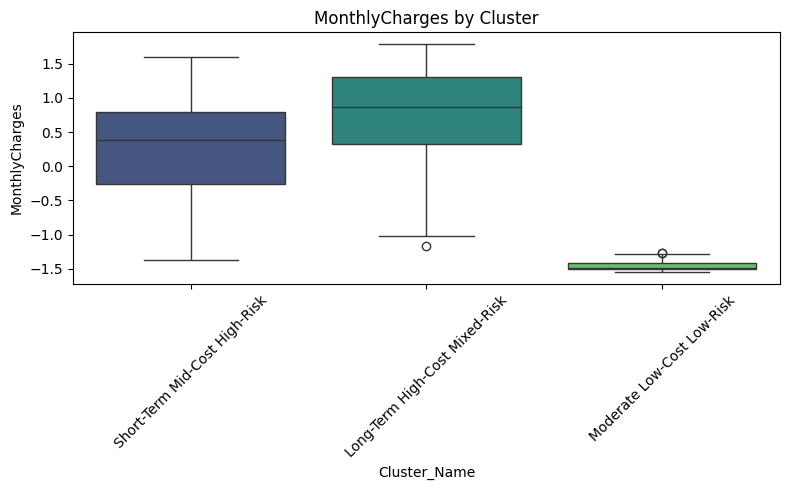

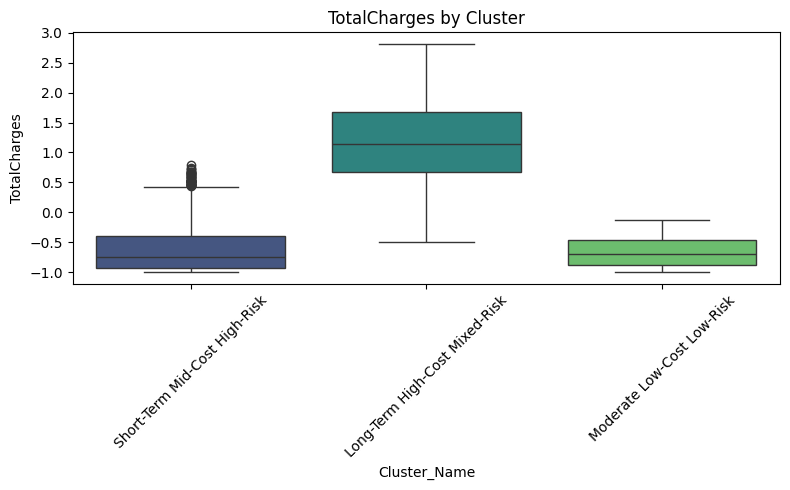

In [17]:
# Boxplots for Numerical Features by Cluster
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=X_clustered, x='Cluster_Name', y=feature, hue='Cluster_Name', palette='viridis', legend=False)
    plt.title(f'{feature} by Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Bar Plots for Top Categorical Features

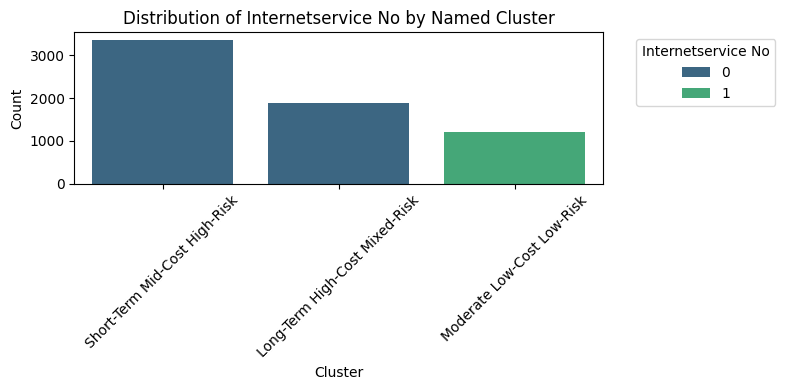

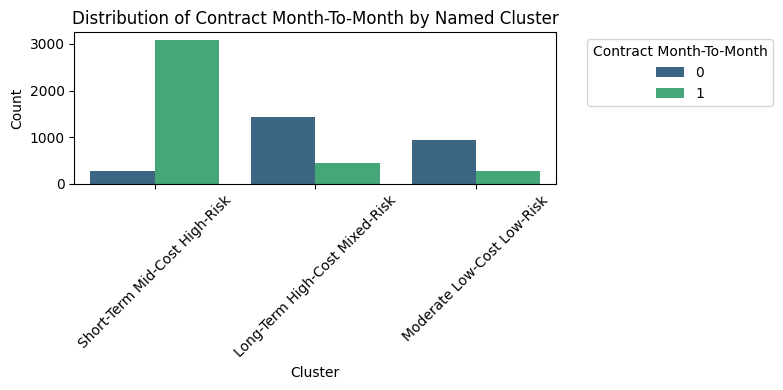

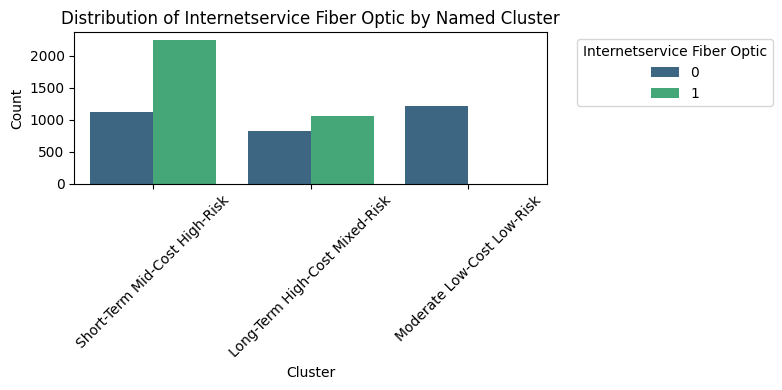

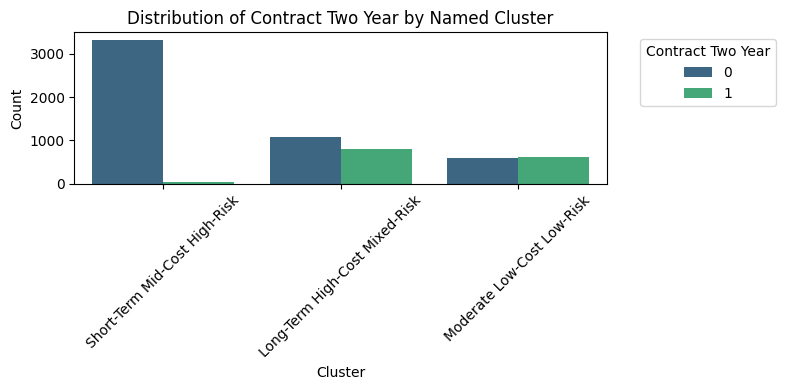

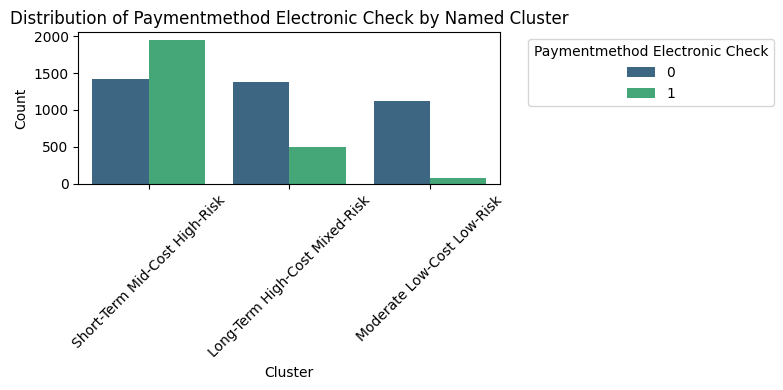

In [18]:
# Bar Plots for Top Categorical Features by Cluster
if categorical_columns:
    variances = X_clustered[categorical_columns].groupby(X_clustered['Cluster']).mean().var()
    top_categorical = variances.nlargest(5).index.tolist()

    for col in top_categorical:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=X_clustered, x='Cluster_Name', hue=col, palette='viridis')
        plt.title(f'Distribution of {col.replace("_", " ").title()} by Named Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Heatmap

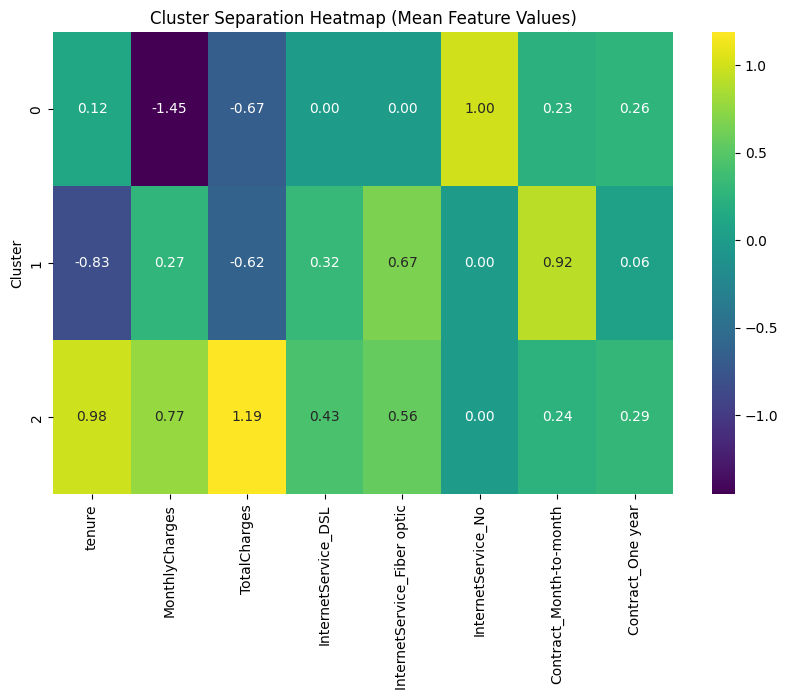

In [19]:
# Cluster Separation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary[numerical_features + categorical_columns[:5]], annot=True, cmap='viridis', fmt='.2f')
plt.title('Cluster Separation Heatmap (Mean Feature Values)')
plt.show()

### Cluster Summary

In [20]:
# Mean Values
print("Cluster Summary (Mean Values):")
print(cluster_summary)

Cluster Summary (Mean Values):
         SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
Cluster                                                                
0             0.034768  0.534768    0.447848  0.117474      1.000000   
1             0.190434  0.248960    0.126560 -0.831474      0.874629   
2             0.158983  0.661367    0.320085  0.982349      0.903021   

         PaperlessBilling  MonthlyCharges  TotalCharges  gender_Female  \
Cluster                                                                  
0                0.298841       -1.453076     -0.671347       0.496689   
1                0.691622        0.271039     -0.618690       0.500000   
2                0.672496        0.768424      1.187272       0.472178   

         gender_Male  ...  StreamingMovies_No internet service  \
Cluster               ...                                        
0           0.503311  ...                                  1.0   
1           0.469994  ...              

### Churn Distribution by Cluster

In [21]:
# Evaluate clustering vs. Churn
print("\nChurn Distribution by Cluster:")
print(churn_by_cluster)


Churn Distribution by Cluster:
Churn           0         1
Cluster                    
0        0.942053  0.057947
1        0.133987  0.866013
2        0.660837  0.339163


### Bar plot of churn distribution by cluster

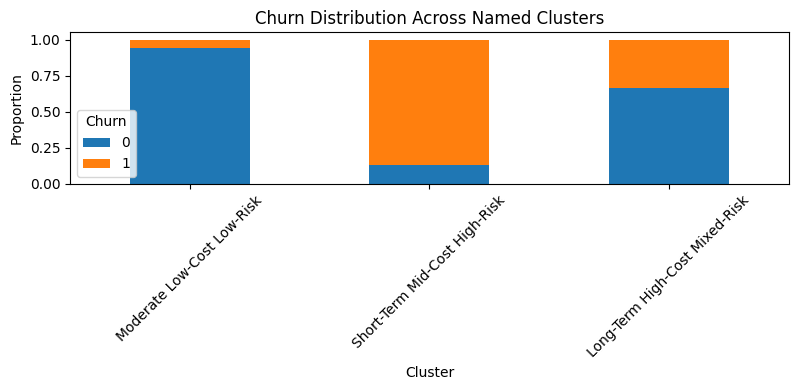

In [22]:
# Bar plot of churn distribution by cluster
churn_by_cluster.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Churn Distribution Across Named Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Churn')
plt.xticks(ticks=range(optimal_k), labels=[cluster_names[i] for i in range(optimal_k)], rotation=45)
plt.tight_layout()
plt.show()

## Interpretation of K-Means Clusters

In [23]:
# Interpretation of the 3 clusters with meaningfulness assessment
print("\nInterpretation of K-Means Clusters:")
print("===================================")

for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id} ({cluster_names[cluster_id]}):")
    cluster_data = cluster_summary.loc[cluster_id, key_features]
    churn_no = churn_by_cluster.loc[cluster_id, 0] if 0 in churn_by_cluster.columns else 0
    churn_yes = churn_by_cluster.loc[cluster_id, 1] if 1 in churn_by_cluster.columns else 0

    interpretation = []
    if cluster_data['tenure'] > 0.5:
        interpretation.append("Long-term customers (high tenure)")
    elif cluster_data['tenure'] < -0.5:
        interpretation.append("Short-term customers (low tenure)")
    else:
        interpretation.append("Average tenure customers")

    if cluster_data['MonthlyCharges'] > 0.5:
        interpretation.append("High monthly charges")
    elif cluster_data['MonthlyCharges'] < -0.5:
        interpretation.append("Low monthly charges")
    else:
        interpretation.append("Moderate monthly charges")

    if cluster_data['Contract_Month-to-month'] > 0.7:
        interpretation.append("Mostly month-to-month contracts")
    elif cluster_data['Contract_One year'] > 0.5 or cluster_data['Contract_Two year'] > 0.5:
        interpretation.append("Mostly long-term contracts (one or two years)")
    else:
        interpretation.append("Mixed contract types")

    if churn_yes > 0.5:
        interpretation.append("High churn risk (>50% churn)")
    elif churn_yes < 0.2:
        interpretation.append("Low churn risk (<20% churn)")
    else:
        interpretation.append("Moderate churn risk (20-50% churn)")

    print(" - " + "; ".join(interpretation))
    if churn_yes > 0.5:
        print(" - Business Insight: Target with retention offers or improved services.")
    elif churn_yes < 0.2:
        print(" - Business Insight: Retain with loyalty rewards or upsell opportunities.")
    else:
        print(" - Business Insight: Investigate satisfaction drivers to improve retention.")


Interpretation of K-Means Clusters:

Cluster 0 (Moderate Low-Cost Low-Risk):
 - Average tenure customers; Low monthly charges; Mostly long-term contracts (one or two years); Low churn risk (<20% churn)
 - Business Insight: Retain with loyalty rewards or upsell opportunities.

Cluster 1 (Short-Term Mid-Cost High-Risk):
 - Short-term customers (low tenure); Moderate monthly charges; Mostly month-to-month contracts; High churn risk (>50% churn)
 - Business Insight: Target with retention offers or improved services.

Cluster 2 (Long-Term High-Cost Mixed-Risk):
 - Long-term customers (high tenure); High monthly charges; Mixed contract types; Moderate churn risk (20-50% churn)
 - Business Insight: Investigate satisfaction drivers to improve retention.


In [24]:
# Assess if clusters are meaningful
print("\nCluster Meaningfulness Assessment:")
print("==================================")
if silhouette_avg > 0.5:
    print(" - Silhouette Score: High (>0.5), indicating well-separated clusters.")
elif silhouette_avg > 0.2:
    print(" - Silhouette Score: Moderate (0.2-0.5), suggesting reasonable separation.")
else:
    print(" - Silhouette Score: Low (<0.2), clusters may not be distinct.")
if davies_bouldin < 1.0:
    print(" - Davies-Bouldin: Low (<1.0), indicating good cluster separation.")
else:
    print(" - Davies-Bouldin: High (>=1.0), suggesting potential overlap.")
numerical_significant = all(p < 0.05 for p in anova_results.values())
categorical_significant = all(p < 0.05 for p in chi2_results.values())
if numerical_significant and categorical_significant:
    print(" - Statistical Tests: All key features show significant differences (p<0.05), confirming distinct groups.")
elif numerical_significant or categorical_significant:
    print(" - Statistical Tests: Some features show significant differences, suggesting partially distinct groups.")
else:
    print(" - Statistical Tests: No significant differences, clusters may not represent distinct groups.")


Cluster Meaningfulness Assessment:
 - Silhouette Score: Moderate (0.2-0.5), suggesting reasonable separation.
 - Davies-Bouldin: High (>=1.0), suggesting potential overlap.
 - Statistical Tests: All key features show significant differences (p<0.05), confirming distinct groups.
